In [1]:
# import the necessary packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
DIRECTORY = r"C:\Users\hp\Desktop\Face-Mask-Detection-master\dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [5]:
print(" loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

 loading images...


In [9]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',padding = 'same', input_shape=(224, 224, 3))(headModel)
headModel = tf.keras.layers.MaxPooling2D(7, 7)(headModel)
headModel = tf.keras.layers.Conv2D(128, (3, 3),padding = 'same', activation='relu')(headModel)
headModel = tf.keras.layers.Conv2D(256, (3, 3),padding = 'same', activation='relu')(headModel)
headModel = tf.keras.layers.Flatten()(headModel)
headModel = tf.keras.layers.Dense(128, activation='relu')(headModel)
headModel = Dropout(0.1)(headModel)
headModel = tf.keras.layers.Dense(2, activation='softmax')(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

E:\anaconda\envs\tensorflow\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [12]:
INIT_LR = 1e-5
EPOCH = 15
BS = 32
for layer in baseModel.layers:
	layer.trainable = False

print(" compiling model...")
opt = RMSprop(lr=INIT_LR, decay=INIT_LR / EPOCH)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

print(" training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCH,
	callbacks=[model_checkpoint_callback])

 compiling model...
 training head...
  ...
    to  
  ['...']
Train for 95 steps, validate on 767 samples
Epoch 1/15
95/95 [==============================] - 74s 776ms/step - loss: 0.6515 - accuracy: 0.7317 - val_loss: 0.6110 - val_accuracy: 0.7255
Epoch 2/15
95/95 [==============================] - 68s 716ms/step - loss: 0.5399 - accuracy: 0.8721 - val_loss: 0.5084 - val_accuracy: 0.8302
Epoch 3/15
95/95 [==============================] - 67s 708ms/step - loss: 0.3950 - accuracy: 0.9166 - val_loss: 0.4400 - val_accuracy: 0.8261
Epoch 4/15
95/95 [==============================] - 68s 714ms/step - loss: 0.2843 - accuracy: 0.9308 - val_loss: 0.3655 - val_accuracy: 0.8478
Epoch 5/15
95/95 [==============================] - 68s 717ms/step - loss: 0.2230 - accuracy: 0.9351 - val_loss: 0.3064 - val_accuracy: 0.8696
Epoch 6/15
95/95 [==============================] - 67s 709ms/step - loss: 0.1775 - accuracy: 0.9476 - val_loss: 0.3186 - val_accuracy: 0.8641
Epoch 7/15
95/95 [=================

In [13]:
test_loss, test_acc = model.evaluate(testX, testY)
print('\nTest accuracy:', test_acc)

767/767 [==============================] - 15s 19ms/sample - loss: 0.2634 - accuracy: 0.9035

Test accuracy: 0.9035202


In [14]:
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


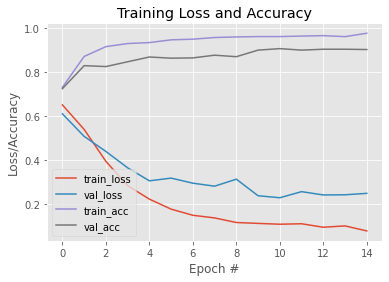

In [16]:
N = EPOCH
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()
print("[INFO] saving TFlite detector model...")
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

[INFO] saving TFlite detector model...


In [19]:
import tempfile
import os
_, model_accuracy = model.evaluate(
    testX,testY, verbose=0)

print('test accuracy:', model_accuracy)

_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

test accuracy: 0.9035202
Saved baseline model to: C:\Users\hp\AppData\Local\Temp\tmpp5yfzro8.h5


In [20]:

def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

print("Size ofthe model: %.2f bytes" % (get_gzipped_model_size(keras_file)))

Size ofthe model: 12624566.00 bytes
